In [27]:
from typing import Annotated, Sequence, List, Literal,TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.types import Command
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display
from dotenv import load_dotenv
from langchain_experimental.tools import PythonREPLTool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
import pprint

In [28]:
## Did not work, can skip

In [29]:
load_dotenv()

True

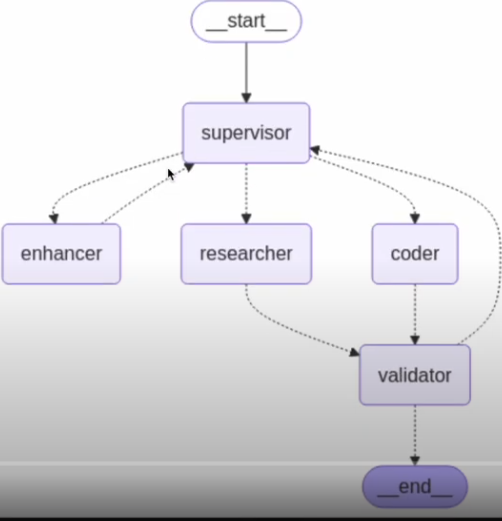

In [30]:
llmLlama=ChatGroq(model="llama-3.1-8b-instant")

In [31]:
tavily_search=TavilySearchResults(max_results=2)

In [32]:
python_repl_tool=PythonREPLTool()

In [33]:
# illustrations
command="""
x=5
print(str(x)+"h")
"""

print(python_repl_tool.invoke(input=command).strip())

5h


In [34]:
class Supervisor(BaseModel):
    next_action: Literal["enhancer","researcher","coder"]=Field(
        description="""
        Determines which specialist to activate next in the workflow sequence:
        'enhancer':  when user input requires clarification, expansion or refinement,
        'researcher': when additional facts, context, or data collection is necessary,
        'coder': when implementation, computation, or technical problem-solving is required
        """
    )
    reason: str = Field(
        description="""
        Detailed justification for the routing decision, explaining the rationale behind selecting the particular
        specialist and how this advances the task towards completion
        """
           )

In [35]:
def supervisor_node(state:MessagesState) -> Command[Literal["enhancer","researcher","coder"]]:
    system_prompt="""
                You are a workflow supervisor managing a team of three specialized agents: Prompt Enhancer, Researcher
                and Coder. Your role is to orchestrate the workflow by selecting the most appropriate next agent based on
                the current state and needs of the task. Provide a clear, concise rationale for each decision to ensure
                transparency in your decision-making process.

                **Team Members**
                1. **Prompt Enhancer**: Always consider this agent first. They clarify ambigious requests, improve poorly
                defined queries, and ensure the task is well-structured before deeper processing begins
                2. **Researcher**: Specializes in information gathering, fact-finding, and collecting relevant data needed to
                address the user's request
                3. **Coder**: Focusses on technical implementation, calculations, data analysis, algorithm development, and
                coding solutions
        
                **Team Members**
                **Your Responsibilities**
                1. Analyze each user request and agent response for completeness, accuracy, and relevance
                2. Route the task to the most appropriate agent at each decision point
                3. Maintain the workflow momentum by avoiding reduntant agent assignments
                4. Continue the process until the user's request is fully and satisfactorily resolved
        
                Your objective is to create an efficient workflow that leverages each agent's strengths while minimizing
                unnecessary steps, ultimately delivering complete and accurate solutions to use requests
        """

    messages=[{"role":"system","content":system_prompt}]+state["messages"]

    response=llmLlama.with_structured_output(schema=Supervisor).invoke(input=messages)
    goto,reason=response.next_action, response.reason

    print(f"--- Workflow Transition: Supervisor -> {goto.upper()}----")

    return Command(
        update={
            "messages":[HumanMessage(content=reason,name="supervisor")]
            }, 
        goto=goto.lower())

In [36]:
def enhancer_node(state:MessagesState) -> Command[Literal["supervisor"]]:

    """
        Enhancer agent node that improves and clarifies user queries.
        Takes the original user input and transforms it into a more precise,
        actionable request before passing it to the supervisor.
    """

    system_prompt=(
        "You are a Query Refinement Specialist with expertise in transforming vague requests into precise instructions. Your responsibilities include:\n\n"
        "1. Analyzing the original query to identify key intent and requirements\n"
        "2. Resolving any ambiguities without requesting additional user input\n"
        "3. Expanding underdeveloped aspects of the query with reasonable assumptions\n"
        "4. Restructuring the query for clarity and actionability\n"
        "5. Ensuring all technical terminology is properly defined in context\n\n"
        "Important: Never ask questions back to the user. Instead, make informed assumptions and create the most comprehensive version of their request possible."
    )

    messages=[
        {"role":"system","content":system_prompt}
    ] + state["messages"]

    enhanced_query=llmLlama.invoke(input=messages)

    print("--- Workflow Transition: Prompt Enhancer  -> Supervisor ----")

    return Command(
        update={"messages":[HumanMessage(content=enhanced_query.content,name="enhancer")]},
        goto="supervisor"
    )

In [37]:
def research_node(state:MessagesState)->Command[Literal["validator"]]:
    """
        Research agent node that gathers information using Tavily Search
        Takes the current task state, performs relevant research,
        and returns findings for validation.
    """

    research_agent=create_react_agent(
                                    model=llmLlama,
                                    tools=[tavily_search],
                                    state_modifier=("You are an Information Specialist with expertise in comprehensive research. Your responsibilities include:\n\n"
                                        "1. Identifying key information needs based on the query context\n"
                                        "2. Gathering relevant, accurate, and up-to-date information from reliable sources\n"
                                        "3. Organizing findings in a structured, easily digestible format\n"
                                        "4. Citing sources when possible to establish credibility\n"
                                        "5. Focusing exclusively on information gathering - avoid analysis or implementation\n\n"
                                        "Provide thorough, factual responses without speculation where information is unavailable."
                    ))

    result=research_agent.invoke(input=state)
    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content,name="researcher")]},
        goto="validator")

In [38]:
def code_node(state:MessagesState) -> Command[Literal["validator"]]:
    code_agent=create_react_agent(
                                model=llmLlama,
                                tools=[python_repl_tool],
                                state_modifier=("You are a coder and analyst. Focus on mathematical calculations, analyzing, solving math questions, "
                                    "and executing code. Handle technical problem-solving and data tasks.")
                                 )
    result=code_agent.invoke(input=state)
    print(f"--- Workflow Transition: Coder -> Validator ---")
    return Command(
        update={
            "message": [HumanMessage(content=result["messages"][-1].content,name="coder")]
        },
        goto="validator"
    )

In [39]:
class Validator(BaseModel):
    next_action: Literal["supervisor","finish"]=Field(
        description="Specifies the next worker in the pipeline: 'supervisor' to continue or 'finish'"
    )
    reason: str=Field(description="The reason for this decision")

In [40]:
def validator_node(state:MessagesState)-> Command[Literal["supervisor",END]]:
    user_question=state["messages"][0].content
    agent_answer=state["messages"][-1].content

    system_prompt='''
    Your task is to ensure reasonable quality. 
    Specifically, you must:
    - Review the user's question (the first message in the workflow).
    - Review the answer (the last message in the workflow).
    - If the answer addresses the core intent of the question, even if not perfectly, signal to end the workflow with 'FINISH'.
    - Only route back to the supervisor if the answer is completely off-topic, harmful, or fundamentally misunderstands the question.
    
    - Accept answers that are "good enough" rather than perfect
    - Prioritize workflow completion over perfect responses
    - Give benefit of doubt to borderline answers
    
    Routing Guidelines:
    1. 'supervisor' Agent: ONLY for responses that are completely incorrect or off-topic.
    2. Respond with 'finish' in all other cases to end the workflow.
    '''

    messages=[
        {"role":"system","content":system_prompt},
        {"role":"user","content":user_question},
        {"role":"assistant","content":agent_answer}
    ]

    response=llmLlama.with_structured_output(schema=Validator).invoke(input=messages)

    reason,goto=response.reason,response.next_action

    if goto=="finish":
        goto=END
        print("---- Transitioning to END ----")
    else:
        print(f"--- Workflow Transition: Validator -> Supervisor ---")

    return Command(update={"messages":[HumanMessage(content=reason,name="validator")]},goto=goto)

In [41]:
graph=StateGraph(state_schema=MessagesState)

In [42]:
graph.add_node(node="supervisor",action=supervisor_node)

In [43]:
graph.add_node(node="enhancer",action=enhancer_node)

In [44]:
graph.add_node(node="researcher", action=research_node)

In [45]:
graph.add_node(node="coder",action=code_node)

In [46]:
graph.add_node(node="validator",action=validator_node)

In [47]:
graph.add_edge(start_key=START,end_key="supervisor")

In [48]:
app=graph.compile()

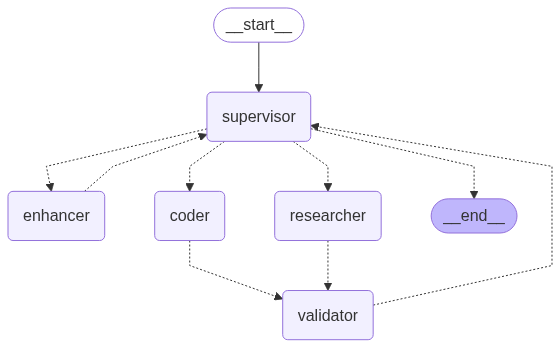

In [49]:
display(Image(data=app.get_graph().draw_mermaid_png()))

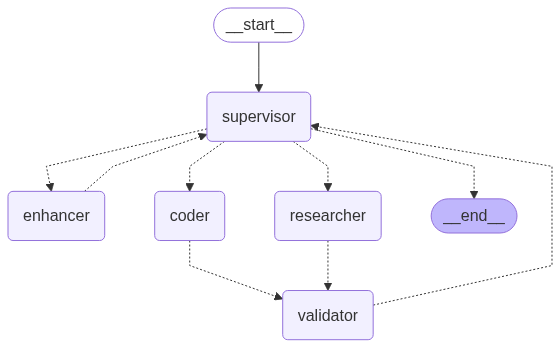

In [50]:
display(Image(data=app.get_graph(xray=True).draw_mermaid_png()))

In [51]:
inputs = {
    "messages": [
        ("user", "Weather in Chennai"),
    ]
}

for event in app.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        last_message = value.get("messages", [])[-1] if "messages" in value else None
        if last_message:
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint(last_message, indent=2, width=80, depth=None)
            print()

--- Workflow Transition: Supervisor -> CODER----
"Output from node 'supervisor':"
HumanMessage(content='The user query is requesting general information about the weather in Chennai, which can be easily answered by a coder, so the task will be routed to the coder for a quick reply.', additional_kwargs={}, response_metadata={}, name='supervisor', id='68d9f241-f37d-41e7-a858-8649e39241b0')

--- Workflow Transition: Coder -> Validator ---
---- Transitioning to END ----
"Output from node 'validator':"
HumanMessage(content='The answer to the user query is a general piece of information that can be easily provided by a coder.', additional_kwargs={}, response_metadata={}, name='validator', id='bc786166-42da-41ea-b9bf-ef068db47ecf')



In [52]:
response=app.invoke(input=inputs)

BadRequestError: Error code: 400 - {'error': {'message': "tool call validation failed: parameters for tool Supervisor did not match schema: errors: [missing properties: 'next_action', 'reason']", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<function=Supervisor> {"name":"Supervisor","description":"","parameters":{"next_action":"enhancer","reason":"User query about weather in Chennai is ambiguous and requires clarification to ensure accuracy. The prompt enhancer will assist in refining the query to obtain the most relevant information."}}</function>'}}

In [ ]:
response=app.invoke(input=inputs)

--- Workflow Transition: Supervisor -> RESEARCHER----
---- Transitioning to END ----
